thicknesses: [ 30. 100.], roughnesses: [0.82241649 0.36915993], slds: [16.21254033 11.71786137]


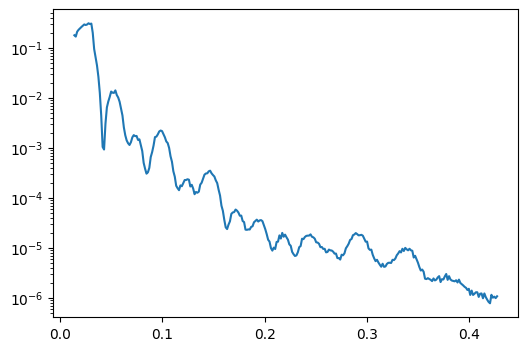

In [58]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from model_fused import PhysicsLayer

from reflecto.simulator.simulator import XRRSimulator, tth2q_wavelen

wavelen: float = 1.54  # (nm)
tth_min: float = 0.2   # degree
tth_max: float = 6.0
tth_n: int = 300
tths: np.ndarray = np.linspace(tth_min, tth_max, tth_n)
qs: np.ndarray = tth2q_wavelen(tths, wavelen)

xrr_simulator = XRRSimulator(qs, 2, 1, has_footprint=True)
thicknesses, roughnesses, slds, refl = next(xrr_simulator.make_params_refl())

print(f"thicknesses: {thicknesses}, roughnesses: {roughnesses}, slds: {slds}")

fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.plot(qs, refl)
ax.set_yscale("log")

plt.show()

In [59]:
refl_tensor = torch.tensor(np.log10(refl), dtype=torch.float32).unsqueeze(0)  # (1, Q)
qs_tensor = torch.tensor(qs, dtype=torch.float32)

print("실제 파라미터:")
print(f"두께: {thicknesses} Å")
print(f"거칠기: {roughnesses} Å")
print(f"SLD: {slds} Å^-2")

실제 파라미터:
두께: [ 30. 100.] Å
거칠기: [0.82241649 0.36915993] Å
SLD: [16.21254033 11.71786137] Å^-2


In [60]:
# 주피터 셀 3: PhysicsLayer 실행
# PhysicsLayer 초기화
physics_layer = PhysicsLayer(qs_tensor, n_layers=2)

# 추정 실행
with torch.no_grad():
    est_thickness, confidence = physics_layer(refl_tensor)

# 결과 출력
print("\nPhysicsLayer 추정 결과:")
print(f"추정 두께: {est_thickness[0].numpy()} Å")
print(f"실제 두께: {thicknesses} Å")
print(f"MAE: {np.mean(np.abs(est_thickness[0].numpy()[:len(thicknesses)] - thicknesses)):.2f} Å")

[ 39  58  70  85 111]

PhysicsLayer 추정 결과:
추정 두께: [ 71.752655 130.38362 ] Å
실제 두께: [ 30. 100.] Å
MAE: 36.07 Å


In [61]:
import scipy as scp
import scipy.signal.windows as fft_windows


def xrr_fft(x, y, d=None, window=2, n=None, step_num: int = 1000):
    """
    FFT 변환 (XRR 분석 전용)

    """
    # 등간격 보간
    f_cubic = scp.interpolate.interp1d(x, y, kind="cubic")
    x = np.linspace(x.min(), x.max(), step_num)
    y = f_cubic(x)

    if d is None:
        d = x[1] - x[0]

    N = len(y)
    if window == 0:
        w = np.ones(N)
    elif window == 1:
        w = fft_windows.hann(N)
    elif window == 2:
        w = fft_windows.hamming(N)
    else:
        w = fft_windows.flattop(N)

    if n is None:
        n = N

    yf = 2 / N * np.abs(scp.fftpack.fft(w * y / np.mean(w), n=n))
    xf = scp.fftpack.fftfreq(n, d=d)
    return xf[: n // 2], yf[: n // 2]

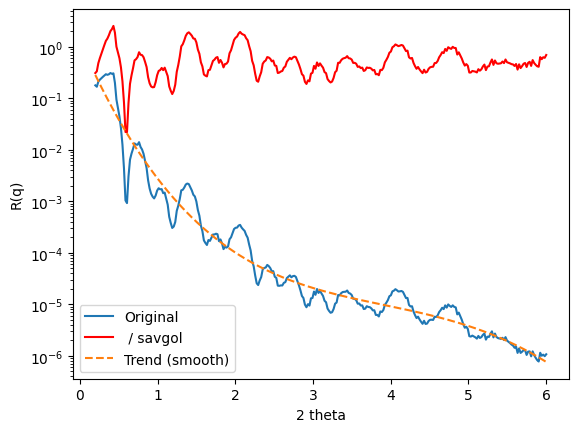

In [62]:
from itertools import combinations_with_replacement

from scipy import signal
from scipy.signal import argrelmax

# 주피터 셀 4: 신호 처리 과정 시각화 (FFT)
# FFT 계산 (PhysicsLayer 내부 과정)
R_log = np.log10(refl)
window_len = len(R_log)

R_smooth = signal.savgol_filter(R_log, window_length=window_len, polyorder=4, mode='interp')
savgol = 10 ** R_smooth
R_savgol = refl / savgol
R_savgol = R_savgol / (R_savgol[0] + 1e-12) * refl.max()

plt.figure()
plt.plot(tths, refl, label='Original')
plt.plot(tths, R_savgol, label=' / savgol', color='red')
plt.plot(tths, savgol, label='Trend (smooth)', linestyle='--')
plt.xlabel('2 theta')
plt.ylabel('R(q)')
plt.yscale('log')
plt.legend()
plt.show()

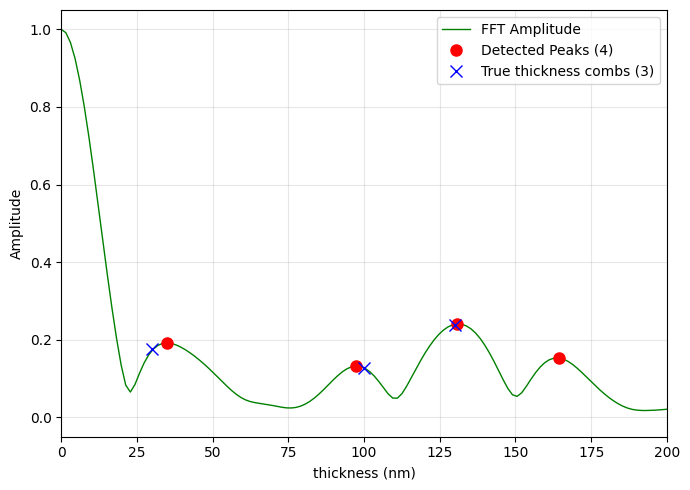

In [63]:
# FFT
xf, yf = xrr_fft(qs, R_savgol, window=2, n=10000)
x_fft = xf * 2 * np.pi
y_fft = yf / yf[0]
# 피크 검출
x_upper = 200
upper_idx = np.searchsorted(x_fft, 200.0)
detected_peaks = []

peak_indices = argrelmax(y_fft[:upper_idx])[0]
# 플롯
fig, ax = plt.subplots(1, 1, figsize=(7, 5))

# FFT 및 피크
ax.plot(x_fft, y_fft, 'g-', linewidth=1, label='FFT Amplitude')
if len(peak_indices) > 0:
    ax.plot(x_fft[peak_indices], y_fft[peak_indices], 'ro', markersize=8, label=f'Detected Peaks ({len(peak_indices)})')

thicknesses_comb = [sum(set(comb)) for comb in combinations_with_replacement(thicknesses, 2)]
thick_comb_idx = [np.argmin(np.abs(x_fft - p)) for p in thicknesses_comb]
ax.plot(thicknesses_comb, y_fft[thick_comb_idx], 'bx', markersize=8, label=f'True thickness combs ({len(thicknesses_comb)})')
ax.set_xlim(0, x_upper)
ax.set_xlabel('thickness (nm)')
ax.set_ylabel('Amplitude')

ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [64]:
def valid_comb(peaks):
    result = []
    ln = len(peaks)
    for i in range(ln):
        for j in range(i, ln):
            remains = set(range(ln)) - {i, j}
            for k in remains:
                a = peaks[i]
                b = peaks[j]
                c = peaks[k]
                if abs(c - a - b) < 5:
                    result.append([a, b, c])
    return result
valid_combs = valid_comb(x_fft[peak_indices])
print(valid_combs)

[[np.float64(34.97147741079439), np.float64(97.31193714308006), np.float64(130.76291553601382)], [np.float64(34.97147741079439), np.float64(130.76291553601382), np.float64(164.21389392894758)]]
